In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

In [11]:
cuda = torch.device('cuda')
cpu = torch.device('cpu')

In [3]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))/255
        self.y = torch.Tensor(D[:, -1:])
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [4]:
Img = Images()
Img.to(device)

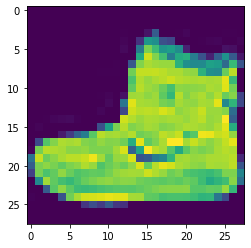

In [5]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [7]:
ratio = 0.001
train, valid = torch.utils.data.random_split(Img, [int(len(Img)*(1 - ratio)), int(len(Img)*ratio)])

In [29]:
dataLoader = torch.utils.data.DataLoader(train, batch_size=500)

# MSE

In [194]:
def onehot(y):
    ret = torch.zeros(y.shape[0], 10)
    ret[torch.arange(y.shape[0]), y.long()] = 1
    return ret

In [195]:
def CE(y, y_pred):
    y = onehot(y) == 1
    return -torch.log(y_pred[y]).sum() - torch.log(1 - y_pred[~y]).sum() + 0

# Logistic Regression

In [196]:
class LogReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogReg, self).__init__()
        
        self.L = nn.Linear(input_size, output_size)
    def forward(self, X):
        return torch.softmax(self.L(X), 1)

In [197]:
model = LogReg(28*28, 10).to(cuda)

In [198]:
opt = optim.Adam(model.parameters())

In [200]:
EPOCHS = 100
for i in tnrange(EPOCHS):
    
    L_cum = 0
    
    for X, y in dataLoader:
        model.zero_grad()
        L = CE(y, model.forward(X.view(X.shape[0], 28*28))) # + C*sum([torch.sum(model.state_dict()[a]**2) if a[-1] == 't' else 0 for a in model.state_dict()])
        L.backward()
        L_cum += L
        opt.step()
    
    # Print
    if (i % (EPOCHS//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L_cum))
    i += 1

Iteration 0 
        L: 90014.7578
Iteration 10 
        L: 78530.9453
Iteration 20 
        L: 67690.5625
Iteration 30 
        L: 60427.4414
Iteration 40 
        L: 55608.6562
Iteration 50 
        L: 52321.5859
Iteration 60 
        L: 50044.2305
Iteration 70 
        L: 48455.5625
Iteration 80 
        L: 47339.2852
Iteration 90 
        L: 46545.6953


In [217]:
EPOCHS = 100
for i in tnrange(EPOCHS):
    
    model.zero_grad()
    
    L_cum = 0
    
    for X, y in dataLoader:
        L = CE(y, model.forward(X.view(X.shape[0], 28*28))) # + C*sum([torch.sum(model.state_dict()[a]**2) if a[-1] == 't' else 0 for a in model.state_dict()])
        L.backward()
        L_cum += L

    opt.step()
    
    # Print
    if (i % (EPOCHS//10)) == 0: print("Iteration %d \n        L: %.4f" % (i, L_cum))
    i += 1

Iteration 0 
        L: 45742.7695
Iteration 10 
        L: 46148.9922
Iteration 20 
        L: 45527.6914
Iteration 30 
        L: 45368.4688
Iteration 40 
        L: 45219.4375
Iteration 50 
        L: 45115.3867
Iteration 60 
        L: 45039.5820


KeyboardInterrupt: 

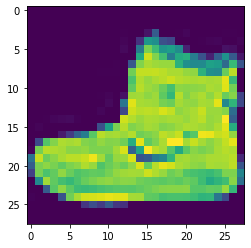

In [218]:
plt.imshow(Img[0][0].reshape(28,28).to(cpu))

In [219]:
Img[0][1]

tensor(9., device='cuda:0')

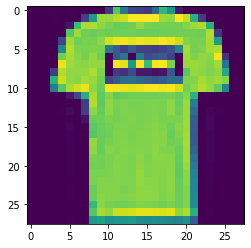

In [220]:
plt.imshow(Img[1][0].reshape(28,28).to(cpu))

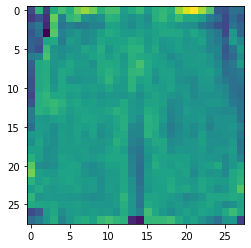

In [227]:
plt.imshow(list(model.parameters())[0].data[1].reshape(28,28).to(cpu))

In [222]:
list(model.parameters())[0].data[0] - list(model.parameters())[0].data[1]

tensor([-5.2598e-01,  1.3640e+00,  2.4233e+00,  1.8813e-01, -1.1545e+00,
        -8.6601e-01, -1.3209e+00, -1.3033e+00, -8.8189e-01, -1.0257e-01,
        -1.0007e+00, -2.4024e-01, -9.7519e-02, -9.1108e-01, -8.5237e-01,
        -4.9063e-01,  2.1873e-01, -2.4227e-01, -1.9793e-01, -1.1497e+00,
        -1.2466e+00, -2.4679e+00, -2.0479e+00, -1.3785e+00,  1.2963e+00,
         8.9295e-01, -4.2391e-01,  2.0765e+00,  1.8875e+00,  2.3116e+00,
         2.5894e+00, -2.7409e-01,  7.5132e-02, -1.2695e+00, -1.0254e+00,
         1.1009e-01,  3.0741e-01, -2.2586e-02, -4.4738e-01, -2.3375e-01,
        -1.2231e-01,  1.8598e-01,  2.1335e-01,  4.7178e-01, -2.5009e-01,
        -5.2562e-01, -1.9455e-01, -4.7169e-01,  1.1378e-01, -7.9530e-02,
        -5.1495e-01,  5.0680e-02,  9.0906e-01,  1.7674e+00, -2.5883e-02,
         2.5883e+00,  1.0841e+00, -3.6145e-01,  1.0916e+00,  5.7574e-02,
         7.0201e-01,  4.6851e-01,  4.5550e-01,  6.8461e-01,  5.2234e-01,
         3.2289e-01, -5.0550e-02, -1.2938e-01,  1.1

In [211]:
model.forward(X.reshape(X.shape[0], 28*28)).argmax(1) - y

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,
         0., -2.,  0.,  0., -4.,  0.,  4.,  0.,  0., -2., -4.,  0.,  0., -4.,
         0.,  0.,  0.,  3.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  2.,
         0.,  0.,  0.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  3., -5.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0., -2.,  0.,  0.,
        -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -2.,  0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  

In [135]:
model.forward(X.reshape(X.shape[0], 28*28)).max(1)[0].mean()

tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)